In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
%matplotlib inline

In [2]:
IDS_df = pd.read_csv("data/ids.csv")

# To display the top 5 rows
# IDS_df.head(5)
IDS_df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [3]:
IDS_df = IDS_df.drop('Timestamp', axis=1)
# IDS_df.columns

In [4]:
# for i in range(len(IDS_df.columns)):
#     print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

In [5]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(350990, 79)


In [6]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

2390


In [7]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [8]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(349795, 79)


In [9]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


Examine the proportion of types of traffic:

In [10]:
IDS_df['Label'].value_counts()

Benign                      159133
Infilteration                39672
DoS attacks-SlowHTTPTest     20000
FTP-BruteForce               20000
Bot                          20000
DoS attacks-Hulk             20000
DDOS attack-HOIC             20000
DoS attacks-GoldenEye        20000
SSH-Bruteforce               20000
DoS attacks-Slowloris        10990
Name: Label, dtype: int64

Convert all non-normal observations into a single class:

In [11]:
def get_label(text):
    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9

IDS_df["Label"] = IDS_df["Label"].apply(get_label)

In [12]:
#y = IDS_df["Label"].values
print(IDS_df["Label"].value_counts())

0    159133
1     39672
9     20000
8     20000
7     20000
6     20000
5     20000
4     20000
3     20000
2     10990
Name: Label, dtype: int64


Convert all categorical features into numerical form:

In [13]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])

Split the dataset into normal and abnormal observations:

In [14]:
IDS_df_normal = IDS_df[IDS_df["Label"] == 0].sample(50000)  # Taking only 50000 samples to balance. Change this as required.
IDS_df_abnormal = IDS_df[IDS_df["Label"] != 0]
y_normal = IDS_df_normal.pop("Label").values
X_normal = IDS_df_normal.values
y_anomaly = IDS_df_abnormal.pop("Label").values
X_anomaly = IDS_df_abnormal.values

Train-test split the dataset:

In [15]:
from sklearn.model_selection import train_test_split

X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=11)

X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(
    X_anomaly, y_anomaly, test_size=0.2, random_state=11, stratify=y_anomaly)

import numpy as np

X_train = np.concatenate((X_normal_train, X_anomaly_train))
y_train = np.concatenate((y_normal_train, y_anomaly_train))
X_test = np.concatenate((X_normal_test, X_anomaly_test))
y_test = np.concatenate((y_normal_test, y_anomaly_test))

# X_train = np.concatenate((X_normal_train[:10000], X_anomaly_train[:10000]))
# y_train = np.concatenate((y_normal_train[:10000], y_anomaly_train[:10000]))
# X_test = np.concatenate((X_normal_test[:1000], X_anomaly_test[:1000]))
# y_test = np.concatenate((y_normal_test[:1000], y_anomaly_test[:1000]))

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(192529, 78)
(48133, 78)
(192529,)
(48133,)


In [17]:
batch_size = 1000

# Pytorch
X_train  = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train, y_train)
valid = torch.utils.data.TensorDataset(X_test, y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

print('Completed loading data')

Completed loading data


In [18]:
train_loader.dataset.tensors[0].shape

torch.Size([192529, 78])

In [21]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
# Defining the DNN model
input_size = train_loader.dataset.tensors[0].shape[1]
hidden_layers = [128]
output_size = 10

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
#         self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
#         self.activ2 = nn.ReLU()
        
#         self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
#         self.activ3 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        x = self.layer2(x)
#         x = self.activ2(x)
        
#         x = self.layer3(x)
#         x = self.activ3(x)
        
#         x = self.layer4(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# SGD Optimizer
learning_rate = 0.0001
# TODO: Try SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MLP(
  (layer1): Linear(in_features=78, out_features=128, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
print('Start training...')
start_time = time.time()
    
epochs = 500

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for e in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        train = data.to(device)
        #print(labels)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()

        if count % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for data, labels in valid_loader:
                valid = data.to(device)
                #print('Lables:', labels)
                
                labels = labels.to(device)

                # Forward propagation
                outputs = model(valid)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                #print('Predicted: ', predicted)
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

        count += 1

end_time = time.time()
print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
    

Start training...
Epoch: 1 Iteration: 0  Loss: 909584.8125  Accuracy: 7 %
Epoch: 3 Iteration: 500  Loss: 4218.39794921875  Accuracy: 59 %
Epoch: 6 Iteration: 1000  Loss: 4317.57568359375  Accuracy: 63 %
Epoch: 8 Iteration: 1500  Loss: 2082.132568359375  Accuracy: 59 %
Epoch: 11 Iteration: 2000  Loss: 2756.876220703125  Accuracy: 68 %
Epoch: 13 Iteration: 2500  Loss: 1122.4595947265625  Accuracy: 65 %
Epoch: 16 Iteration: 3000  Loss: 1546.0135498046875  Accuracy: 65 %
Epoch: 19 Iteration: 3500  Loss: 2396.613037109375  Accuracy: 63 %
Epoch: 21 Iteration: 4000  Loss: 1397.1307373046875  Accuracy: 69 %
Epoch: 24 Iteration: 4500  Loss: 2363.828369140625  Accuracy: 73 %
Epoch: 26 Iteration: 5000  Loss: 1485.408203125  Accuracy: 68 %
Epoch: 29 Iteration: 5500  Loss: 2084.679443359375  Accuracy: 74 %
Epoch: 32 Iteration: 6000  Loss: 1211.1502685546875  Accuracy: 68 %
Epoch: 34 Iteration: 6500  Loss: 1215.8023681640625  Accuracy: 73 %
Epoch: 37 Iteration: 7000  Loss: 1270.429931640625  Accurac

Epoch: 311 Iteration: 60000  Loss: 247.7758026123047  Accuracy: 77 %
Epoch: 314 Iteration: 60500  Loss: 925.552490234375  Accuracy: 77 %
Epoch: 317 Iteration: 61000  Loss: 268.18603515625  Accuracy: 80 %
Epoch: 319 Iteration: 61500  Loss: 388.2151794433594  Accuracy: 79 %
Epoch: 322 Iteration: 62000  Loss: 817.0745849609375  Accuracy: 78 %
Epoch: 324 Iteration: 62500  Loss: 1125.8154296875  Accuracy: 78 %
Epoch: 327 Iteration: 63000  Loss: 575.9903564453125  Accuracy: 76 %
Epoch: 330 Iteration: 63500  Loss: 1851.139892578125  Accuracy: 79 %
Epoch: 332 Iteration: 64000  Loss: 585.001953125  Accuracy: 79 %
Epoch: 335 Iteration: 64500  Loss: 537.973876953125  Accuracy: 79 %
Epoch: 337 Iteration: 65000  Loss: 485.5899963378906  Accuracy: 76 %
Epoch: 340 Iteration: 65500  Loss: 1131.3973388671875  Accuracy: 79 %
Epoch: 342 Iteration: 66000  Loss: 642.083740234375  Accuracy: 77 %
Epoch: 345 Iteration: 66500  Loss: 1967.5496826171875  Accuracy: 76 %
Epoch: 348 Iteration: 67000  Loss: 670.9924

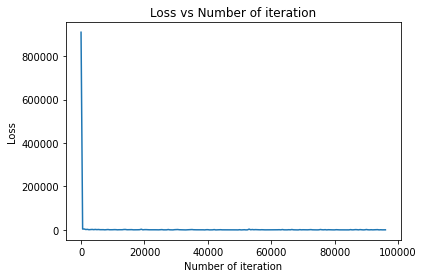

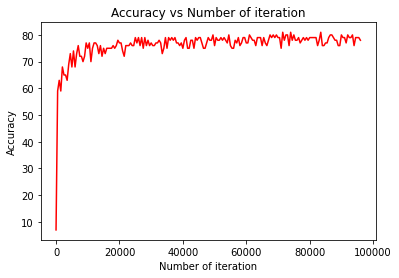

In [23]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.show()